### Check dependencies

In [4]:
# install data augmentation
#!pip install six numpy scipy Pillow scikit-image opencv-python imageio Shapely
!pip install imgaug

### Imports

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, AveragePooling2D
import tensorflow.keras.applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, TensorBoard, EarlyStopping
import datetime, os

#from keras_vggface.vggface import VGGFace
#from keras_squeezenet import SqueezeNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import os 
import cv2
from tqdm import tqdm_notebook
from random import shuffle
import shutil
import pandas as pd
%matplotlib inline
import numpy as np

### Source usage definitions

In [0]:
USE_CLOUD = True
USE_IMAGEAUG = False

#### If will use third party Image Augmentation

In [0]:
# import data augmentation
import imageio
import imgaug as ia

In [0]:
from imgaug import augmenters as iaa
ia.seed(42)

seq = iaa.SomeOf((0, None), [
  iaa.Noop(),
  iaa.Affine(scale=(0.8,1.2)),
  iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (0, 0)}),
  iaa.Add((-10, 10), per_channel=0.5),
  iaa.AddElementwise((-10, 10), per_channel=0.5),
  iaa.ChannelShuffle (0.25),
  iaa.Multiply((0.7, 1.3), per_channel=0.5),
  iaa.MultiplyElementwise((0.9, 1.1)),
  iaa.AdditiveGaussianNoise(scale=(0,15)),
  iaa.GaussianBlur(sigma=(0.0, 0.75)),
  iaa.CoarseDropout(0.01, size_percent=0.5, per_channel=0.5),
  iaa.Invert(0.1, per_channel=0.1),
  iaa.ContrastNormalization((0.5, 3)),
  iaa.ContrastNormalization((0.5, 2), per_channel=0.5),
  iaa.Dropout(p=(0, 0.008), per_channel=0.5),
  iaa.WithChannels(children=iaa.WithChannels(0, iaa.Add((10, 20))) ),    
  iaa.Crop(percent=(0, 0.2))
], random_order=True)

def imaug_data(image):
  global seq
  
  return seq.augment_image(image)

#### If cloud download data from Drive

In [12]:
if USE_CLOUD:
  from google.colab import drive
  drive.mount('/content/gdrive')
  
  ! unzip "/content/gdrive/My Drive/Colab Notebooks/mask/data/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/train/mask/4_mask_000239.jpg  
  inflating: data/train/mask/4_mask_000245.jpg  
  inflating: data/train/mask/4_mask_000248.jpg  
  inflating: data/train/mask/4_mask_000257.jpg  
  inflating: data/train/mask/4_mask_000268.jpg  
  inflating: data/train/mask/4_mask_000279.jpg  
  inflating: data/train/mask/4_mask_000297.jpg  
  inflating: data/train/mask/4_mask_000300.jpg  
  inflating: data/train/mask/4_mask_000301.jpg  
  inflating: data/train/mask/4_mask_000317.jpg  
  inflating: data/train/mask/4_mask_000323.jpg  
  inflating: data/train/mask/4_mask_000326.jpg  
  inflating: data/train/mask/4_mask_000330.jpg  
  inflating: data/train/mask/4_mask_000334.jpg  
  inflating: data/train/mask/4_mask_000354.jpg  
  inflating: data/train/mask/4_mask_000394.jpg  
  inflating: data/train/mask/4_mask_000401.jpg  
  inflating: data/train/mask/4_mask_000408.jpg  
  inflating: data/train/mask/4_mask_000526.jpg  
  inflating: data/

### Model definitions

In [0]:
img_width, img_height = 224, 224
N_CLASSES = 2

DATA_FOLDER_TRAIN = "data/train"
N_EPOCHS = 200
BATCH_SIZE = 32
INIT_LR = 1e-4

TRANSFER_MODEL = 'MobileNet'

#### Load model transfer source and weights

In [116]:
input_tensor = Input(shape=(img_height, img_width, 3))
if TRANSFER_MODEL == 'MobileNet':

  base_model = tensorflow.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', 
                                                         include_top=False,
                                                         input_shape=None,
                                                         input_tensor=input_tensor)
else:
  base_model = keras.applications.resnet.ResNet50(weights="imagenet", 
                                                include_top=False, 
                                                input_tensor=Input(shape=(img_height, img_width, 3)))

#### Attach our model on final of base model

In [0]:
headModel = base_model.output
#headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(N_CLASSES, activation="softmax")(headModel)

Freeze all layers from base model

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

Create model

In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=INIT_LR, decay=INIT_LR / N_EPOCHS),
              metrics=['accuracy'])

Load images from data folder and create generator

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2) # set validation split

if USE_IMAGEAUG:
  train_datagen.preprocessing_function=imaug_data
  
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_datagen.mean = mean

In [123]:
train_generator = train_datagen.flow_from_directory(
    DATA_FOLDER_TRAIN,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') # set as training data

Found 6974 images belonging to 2 classes.


In [124]:
validation_generator = train_datagen.flow_from_directory(
    DATA_FOLDER_TRAIN, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 1742 images belonging to 2 classes.


Add callbacks to check model training early stop and tensorboard

In [0]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model_weights_checkpoint = '/content/gdrive/My Drive/Colab Notebooks/mask/model/mask_mobile_net_128.h5'

## Callback for early stopping the training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=15,
                              verbose=0, 
                              mode='auto')

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_weights_checkpoint, 
                                             monitor='val_accuracy', 
                                             verbose=1, 
                                             save_best_only=True, 
                                             mode='auto')

#### Train model 
(take some time)

In [38]:
hist = model.fit(train_generator,
                 steps_per_epoch = train_generator.samples // BATCH_SIZE, 
                 epochs=N_EPOCHS, 
                 validation_data=validation_generator, 
                 validation_steps = validation_generator.samples // BATCH_SIZE,
                 callbacks = [tensorboard_callback, checkpoint, early_stopping])

Epoch 1/200
217/217 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8322
Epoch 00001: val_accuracy improved from -inf to 0.81944, saving model to /content/gdrive/My Drive/Colab Notebooks/mask/model/mask_mobile_net_n.h5
217/217 [==============================] - 145s 667ms/step - loss: 0.3992 - accuracy: 0.8322 - val_loss: 0.3841 - val_accuracy: 0.8194
Epoch 2/200
217/217 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.8882
Epoch 00002: val_accuracy improved from 0.81944 to 0.83275, saving model to /content/gdrive/My Drive/Colab Notebooks/mask/model/mask_mobile_net_n.h5
217/217 [==============================] - 144s 665ms/step - loss: 0.2556 - accuracy: 0.8882 - val_loss: 0.3465 - val_accuracy: 0.8328
Epoch 3/200
217/217 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9031
Epoch 00003: val_accuracy improved from 0.83275 to 0.83333, saving model to /content/gdrive/My Drive/Colab Notebooks/mask/model/mask_mobile_net_

Plot training and validation

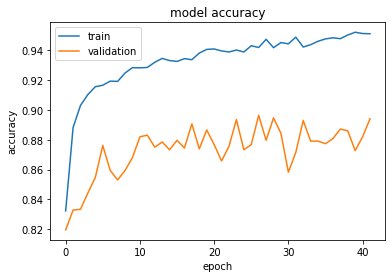

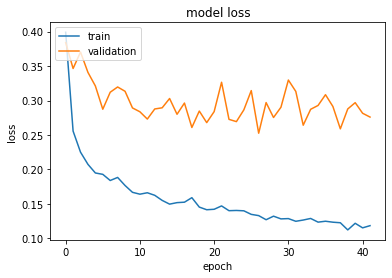

In [42]:
history = hist

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Plot confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import itertools
from sklearn.metrics import plot_confusion_matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
score = model.evaluate(validation_generator, steps = 1)
print("Accuracy = ", score)

1/1 [==============================] - 0s 1ms/step - loss: 0.1281 - accuracy: 0.9688
Accuracy =  [0.1281425952911377, 0.96875]


In [0]:
predictions = model.predict(validation_generator, steps = validation_generator.samples // BATCH_SIZE)
predicted_classes = np.argmax(predictions, axis=1)

In [0]:
true_classes = validation_generator.classes[:predicted_classes.shape[0]]
class_labels = list(validation_generator.class_indices.keys())

In [80]:
accuracy = accuracy_score(true_classes, predicted_classes)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

        mask       0.50      0.53      0.52       859
     no-mask       0.50      0.47      0.49       851

    accuracy                           0.50      1710
   macro avg       0.50      0.50      0.50      1710
weighted avg       0.50      0.50      0.50      1710



In [0]:
ret = confusion_matrix(true_classes, predicted_classes)

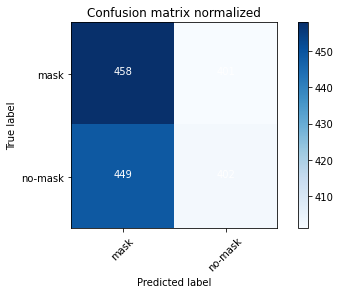

In [93]:
plot_confusion_matrix(ret, 
                      classes=class_labels,
                      title='Confusion matrix normalized', 
                      normalize=False)

#### Show tensorboard

In [0]:
#%load_ext tensorboard

In [0]:
#%tensorboard --logdir logs